Number of valid images with mask: 1915
Number of valid images without mask: 1918


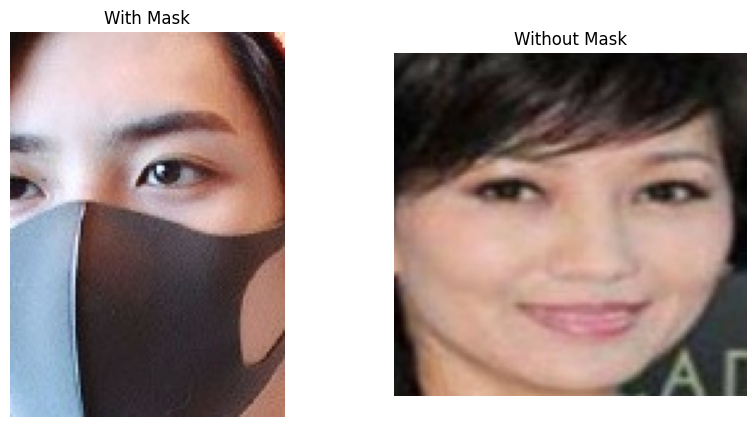

Found 3067 images belonging to 2 classes.
Found 766 images belonging to 2 classes.
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 590ms/step - accuracy: 0.7908 - loss: 0.4312 - val_accuracy: 0.9728 - val_loss: 0.0974
Epoch 2/10
 1/95 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 1.0000 - loss: 0.0744

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 1.0000 - loss: 0.0744 - val_accuracy: 0.9769 - val_loss: 0.0863
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.9644 - loss: 0.1131 - val_accuracy: 0.9823 - val_loss: 0.0649
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 0.0400 - val_accuracy: 0.9810 - val_loss: 0.0720
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 47s 496ms/step - accuracy: 0.9770 - loss: 0.0766 - val_accuracy: 0.9837 - val_loss: 0.0570
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9688 - loss: 0.0933 - val_accuracy: 0.9864 - val_loss: 0.0521
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 862ms/step - accuracy: 0.9793 - loss: 0.0663 - val_accuracy: 0.9810 - val_loss: 0.0503
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 1.0000 - loss: 0.0325 - val_accuracy: 0.9864 - val_loss: 0.0508
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 47s 493ms/step - accuracy: 0.9848 - loss: 0.0516 - val_accuracy: 0.983

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Dataset paths
base_path = "/kaggle/input/face-mask-dataset-with-and-without-mask/facemask-dataset/dataset"
with_mask_dir = os.path.join(base_path, "with_mask")
without_mask_dir = os.path.join(base_path, "without_mask")

# Helper: Get list of valid image files
def get_image_files(folder):
    valid_extensions = [".jpg", ".jpeg", ".png"]
    return [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in valid_extensions]

# Get actual image files
with_mask_files = get_image_files(with_mask_dir)
without_mask_files = get_image_files(without_mask_dir)

print("Number of valid images with mask:", len(with_mask_files))
print("Number of valid images without mask:", len(without_mask_files))

# Function to load image safely
def load_image(path):
    img = cv2.imread(path)
    if img is not None:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        print("Failed to load:", path)
        return None

# Pick first valid images
img_mask = load_image(os.path.join(with_mask_dir, with_mask_files[0]))
img_no_mask = load_image(os.path.join(without_mask_dir, without_mask_files[0]))

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
if img_mask is not None:
    ax[0].imshow(img_mask)
    ax[0].set_title("With Mask")
    ax[0].axis("off")

if img_no_mask is not None:
    ax[1].imshow(img_no_mask)
    ax[1].set_title("Without Mask")
    ax[1].axis("off")

plt.show()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Rescale images and apply basic augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    validation_split=0.2,     # 20% for validation
    horizontal_flip=True,      # Augmentation: flip images
    zoom_range=0.2,            # Random zoom
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    base_path,                 # Base path with 'with mask' and 'without mask' folders
    target_size=(128, 128),    # Resize images
    batch_size=32,
    class_mode='binary',       # Binary classification
    subset='training',          # Training set
    shuffle=True
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'         # Validation set
)

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
# Load MobileNetV2 without top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base layers so they are not trained initially
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dropout(0.3)(x)               # Regularization
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Build final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,          # Start with 10 epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)




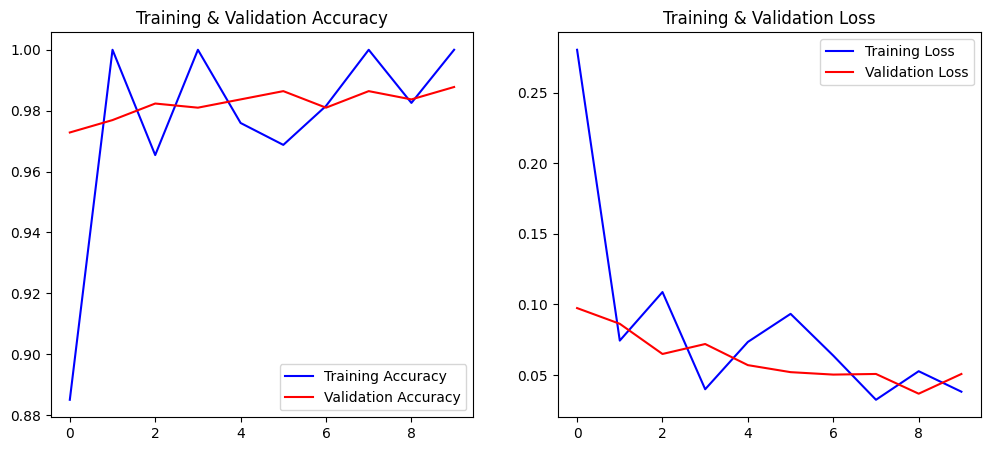

In [7]:
import matplotlib.pyplot as plt

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


Class Indices: {'with_mask': 0, 'without_mask': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


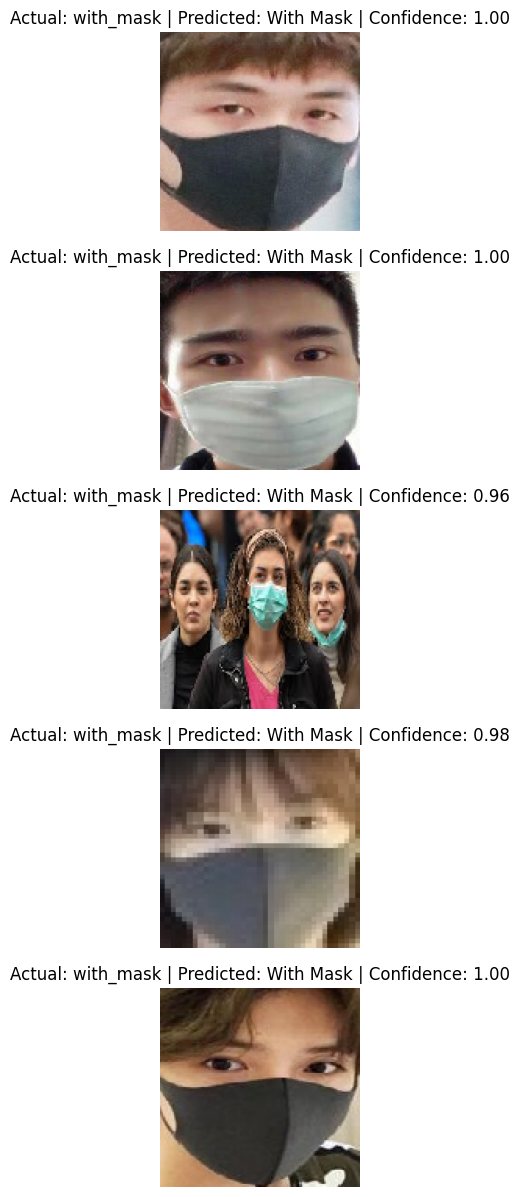

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


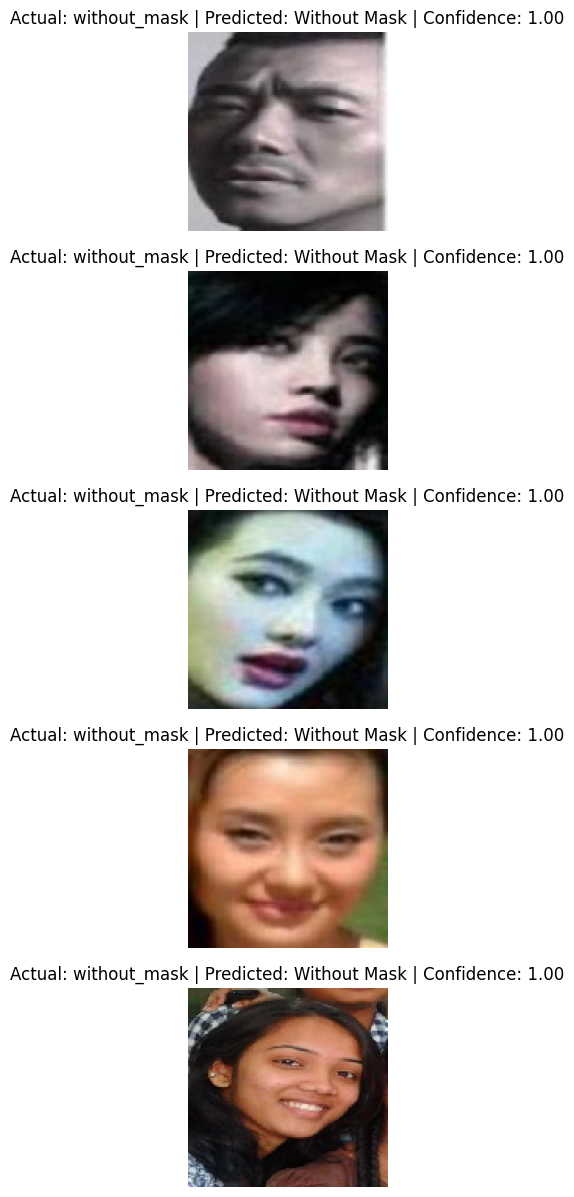

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import os

# Step 1: Get class indices from the training generator
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)  
# Example output: {'with mask': 0, 'without mask': 1}

# Step 2: Create a reverse mapping
idx_to_class = {v:k for k,v in class_indices.items()}

# Step 3: Function to predict and display images
def predict_and_show(folder, num_samples=5):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    files = random.sample(files, min(num_samples, len(files)))  # pick random samples

    plt.figure(figsize=(15,3*num_samples))
    
    for i, file in enumerate(files):
        img_path = os.path.join(folder, file)
        img = image.load_img(img_path, target_size=(128,128))
        img_array = image.img_to_array(img)/255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        pred = model.predict(img_array)[0][0]
        if pred > 0.5:
            predicted_label = idx_to_class[1]  # Label 1
            confidence = pred
        else:
            predicted_label = idx_to_class[0]  # Label 0
            confidence = 1 - pred

        # Plot image
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.axis('off')
        # Format predicted label
        predicted_label_display = str(predicted_label).replace("_", " ").strip().title()

        # Update the plot title
        plt.title(f"Actual: {os.path.basename(folder)} | Predicted: {predicted_label_display} | Confidence: {confidence:.2f}")
        
    
    plt.show()

# Step 4: Test predictions for both classes
predict_and_show(os.path.join(base_path, "with_mask"), num_samples=5)
predict_and_show(os.path.join(base_path, "without_mask"), num_samples=5)

model.save("mask_detector_model.h5")





Class Indices: {'with_mask': 0, 'without_mask': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


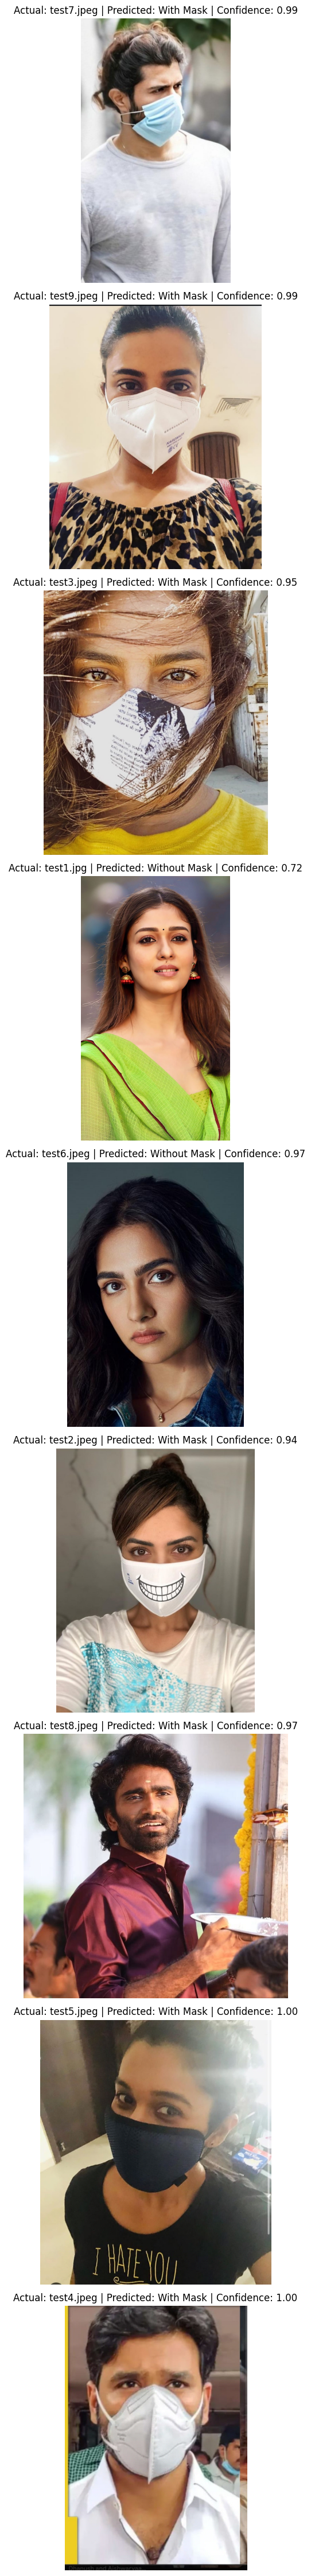

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

# -----------------------------
# STEP 1: Get class indices from training generator
# -----------------------------
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)
# Example: {'with mask': 0, 'without mask': 1}

# Reverse mapping: numeric label -> folder name
idx_to_class = {v:k for k,v in class_indices.items()}

# -----------------------------
# STEP 2: Set test image folder
# -----------------------------
test_folder = "/kaggle/input/testdata"  # Your Kaggle test image folder

# -----------------------------
# STEP 3: Get list of images
# -----------------------------
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]

# -----------------------------
# STEP 4: Loop through images and predict
# -----------------------------
plt.figure(figsize=(15, 5 * len(image_files)))

for i, img_file in enumerate(image_files):
    img_path = os.path.join(test_folder, img_file)
    
    # Load & preprocess
    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = model.predict(img_array)[0][0]
    
    if pred > 0.5:
        predicted_label = idx_to_class[1]  # label 1
        confidence = pred
    else:
        predicted_label = idx_to_class[0]  # label 0
        confidence = 1 - pred
    
    # Display image with prediction
    plt.subplot(len(image_files), 1, i+1)
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    # Format predicted label
    predicted_label_display = str(predicted_label).replace("_", " ").strip().title()

    # Update the plot title
    plt.title(f"Actual: {os.path.basename(img_file)} | Predicted: {predicted_label_display} | Confidence: {confidence:.2f}")


plt.tight_layout()
plt.show()


